In [39]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
import numpy as np
import scipy

# Initial data loading and plotting

### LAKE Parameters for reference

* N_header_lines* --- the number of lines, occupied by file header 
* N_coloumns*     --- the total number of coloumns in the file
* N_Year*         --- the number of coloumn with the number of year (not used in the model)
* N_Month*        --- the number of coloumn with the number of month (not used in the model)
* N_Day*          --- the number of coloumn with the number of day (not used in the model)
* N_Hour*         --- the number of coloumn with the number of hour (not used in the model)
* N_Uspeed*       --- the number of coloumn with x-component speed values,      (m/s)
* N_Vspeed*       --- the number of coloumn with y-component speed values,      (m/s)
* N_Temp*         --- the number of coloumn with air temperature values,        (K)
* N_Hum*          --- the number of coloumn with air humidity values,           (kg/kg)
* N_Pres*         --- the number of coloumn with atmospheric pressure value,s   (Pa)
* N_SWdown*       --- the number of coloumn with net solar radiation values,    (W/m**2)
* N_LWdown*       --- the number of coloumn with net longwave radiation values, (W/m**2)
* N_Precip*       --- the number of coloumn with precipitation intensity,       (m/s)

In [40]:
path_to_burned='raw/YKD_burned_gapfilledCO2_2022.xlsx'
path_to_unburned='raw/YKD_unburned_gapfilledCO2_2022.xlsx'

In [41]:
#read excel sheets as dataframes
df_burned = pd.read_excel(path_to_burned)
df_unburned = pd.read_excel(path_to_unburned)

#drop unnecesarry columns
df_burned = df_burned.drop(columns=['Year', 'DoY', 'Hour', 'NEE_f', 'CH4', 'SoilT_f', 'PPFD_f', 'H', 'LE', 'VPD'])
df_unburned =df_unburned.drop(columns=['Year', 'DoY', 'Hour', 'NEE_f', 'CH4', 'SoilT_f', 'PPFD_f', 'H', 'LE', 'VPD'])

df_burned = df_burned.rename(columns={'Precip':'Precip_mm'})
df_unburned = df_unburned.rename(columns={'Precip (mm)':'Precip_mm'})

In [42]:
df_burned['DateTime']=pd.to_datetime(df_burned['DateTime'])
df_unburned['DateTime']=pd.to_datetime(df_unburned['DateTime'])

In [43]:
#New year month day columns
df_burned['Year']=pd.DatetimeIndex(df_burned['DateTime']).year
df_burned['Month']=pd.DatetimeIndex(df_burned['DateTime']).month
df_burned['Day']=pd.DatetimeIndex(df_burned['DateTime']).day
df_burned['hour']=pd.DatetimeIndex(df_burned['DateTime']).hour

df_unburned['Year']=pd.DatetimeIndex(df_unburned['DateTime']).year
df_unburned['Month']=pd.DatetimeIndex(df_unburned['DateTime']).month
df_unburned['Day']=pd.DatetimeIndex(df_unburned['DateTime']).day
df_unburned['hour']=pd.DatetimeIndex(df_unburned['DateTime']).hour

In [44]:
df_burned.columns

Index(['DateTime', 'Tair_f', 'Wind_Speed', 'Wind_Dir', 'SW_In_f', 'SW_Out',
       'LW_In', 'LW_Out', 'RH', 'Precip_mm', 'Air_Pressure', 'Year', 'Month',
       'Day', 'hour'],
      dtype='object')

In [45]:
df_unburned.columns

Index(['DateTime', 'Tair_f', 'RH', 'Wind_Speed', 'Wind_Dir', 'SW_In_f',
       'SW_Out', 'LW_In', 'LW_Out', 'Precip_mm', 'Air_Pressure', 'Year',
       'Month', 'Day', 'hour'],
      dtype='object')

In [46]:
#aggregate all half-hourly measurements to daily by taking the mean, sum precipitation
df_burned_daily = df_burned.groupby(by=['Year', 'Month', 'Day']).aggregate({
                                                                            'Tair_f': 'mean',
                                                                            'RH': 'mean',
                                                                            'Wind_Speed': 'mean',
                                                                            'Wind_Dir': 'mean',
                                                                            'SW_In_f': 'mean',
                                                                            'SW_Out': 'mean',
                                                                            'LW_In': 'mean',
                                                                            'LW_Out': 'mean',
                                                                            'Precip_mm': 'sum',
                                                                            'Air_Pressure': 'mean'
                                                                            }).reset_index()

#aggregate all half-hourly measurements to daily by taking the mean, sum precipitation
df_unburned_daily = df_unburned.groupby(by=['Year', 'Month', 'Day']).aggregate({
                                                                            'Tair_f': 'mean',
                                                                            'RH': 'mean',
                                                                            'Wind_Speed': 'mean',
                                                                            'Wind_Dir': 'mean',
                                                                            'SW_In_f': 'mean',
                                                                            'SW_Out': 'mean',
                                                                            'LW_In': 'mean',
                                                                            'LW_Out': 'mean',
                                                                            'Precip_mm': 'sum',
                                                                            'Air_Pressure': 'mean'
                                                                            }).reset_index()

In [47]:
#datetimes for daily aggregated data
df_burned_daily['datetime']=pd.to_datetime(df_burned_daily[['Year', 'Month', 'Day']])
df_unburned_daily['datetime']=pd.to_datetime(df_unburned_daily[['Year', 'Month', 'Day']])

#calculate net shortwave and net longwave
df_burned_daily['SW_Net'] = df_burned_daily['SW_In_f']#-df_burned_daily['SW_Out']
df_burned_daily['SW_Net'] = df_burned_daily['SW_Net'].where((df_burned_daily['SW_Net']>0) | (df_burned_daily['SW_Net'].isnull()), 0)

df_unburned_daily['SW_Net'] = df_unburned_daily['SW_In_f']#-df_unburned_daily['SW_Out']
df_unburned_daily['SW_Net'] = df_unburned_daily['SW_Net'].where((df_unburned_daily['SW_Net']>0) | (df_unburned_daily['SW_Net'].isnull()), 0)

df_burned_daily['LW_Net']=df_burned_daily['LW_In']#-df_burned_daily['LW_Out']
df_unburned_daily['LW_Net']=df_unburned_daily['LW_In']#-df_unburned_daily['LW_Out']

#df_unburned_daily.loc[df_unburned_daily['Air_Pressure']<999000, 'Air_Pressure'] = np.nan
#df_burned_daily.loc[df_unburned_daily['Air_Pressure']<999000, 'Air_Pressure'] = np.nan
#last day of unburned air pressure is bad
df_unburned_daily.loc[(df_unburned_daily['Month']==12) & (df_unburned_daily['Day']==31), 'Air_Pressure'] = np.nan


#set rh >= 1 to 0.99

df_burned_daily.loc[df_burned_daily['RH']>=100, 'RH'] = 99
df_unburned_daily.loc[df_unburned_daily['RH']>=100, 'RH'] = 99



def calc_hr(temp, pres, rh):
    temp = temp-273.15
    hr=[]
    
    for i, temp in enumerate(temp):
        if temp>0:
            pws=610.94*np.exp(1)**(17.625*temp/(temp+243.04))
        else:
            pws=611.21*np.exp(1)**(22.587*temp/(temp+273.86))
        
        pw = (pws*rh[i])/100
        
        hr.append(0.62198*pw/(pres[i] - pw))
    return hr

#convert rh from percent to mixing ratio
df_unburned_daily['RH (kg/kg)'] = calc_hr(df_unburned_daily['Tair_f'], df_unburned_daily['Air_Pressure'], df_unburned_daily['RH'])

df_burned_daily['RH (kg/kg)'] = calc_hr(df_burned_daily['Tair_f'], df_burned_daily['Air_Pressure'], df_burned_daily['RH'])


In [48]:
np.mean(df_unburned_daily['Tair_f'])

273.34519027401825

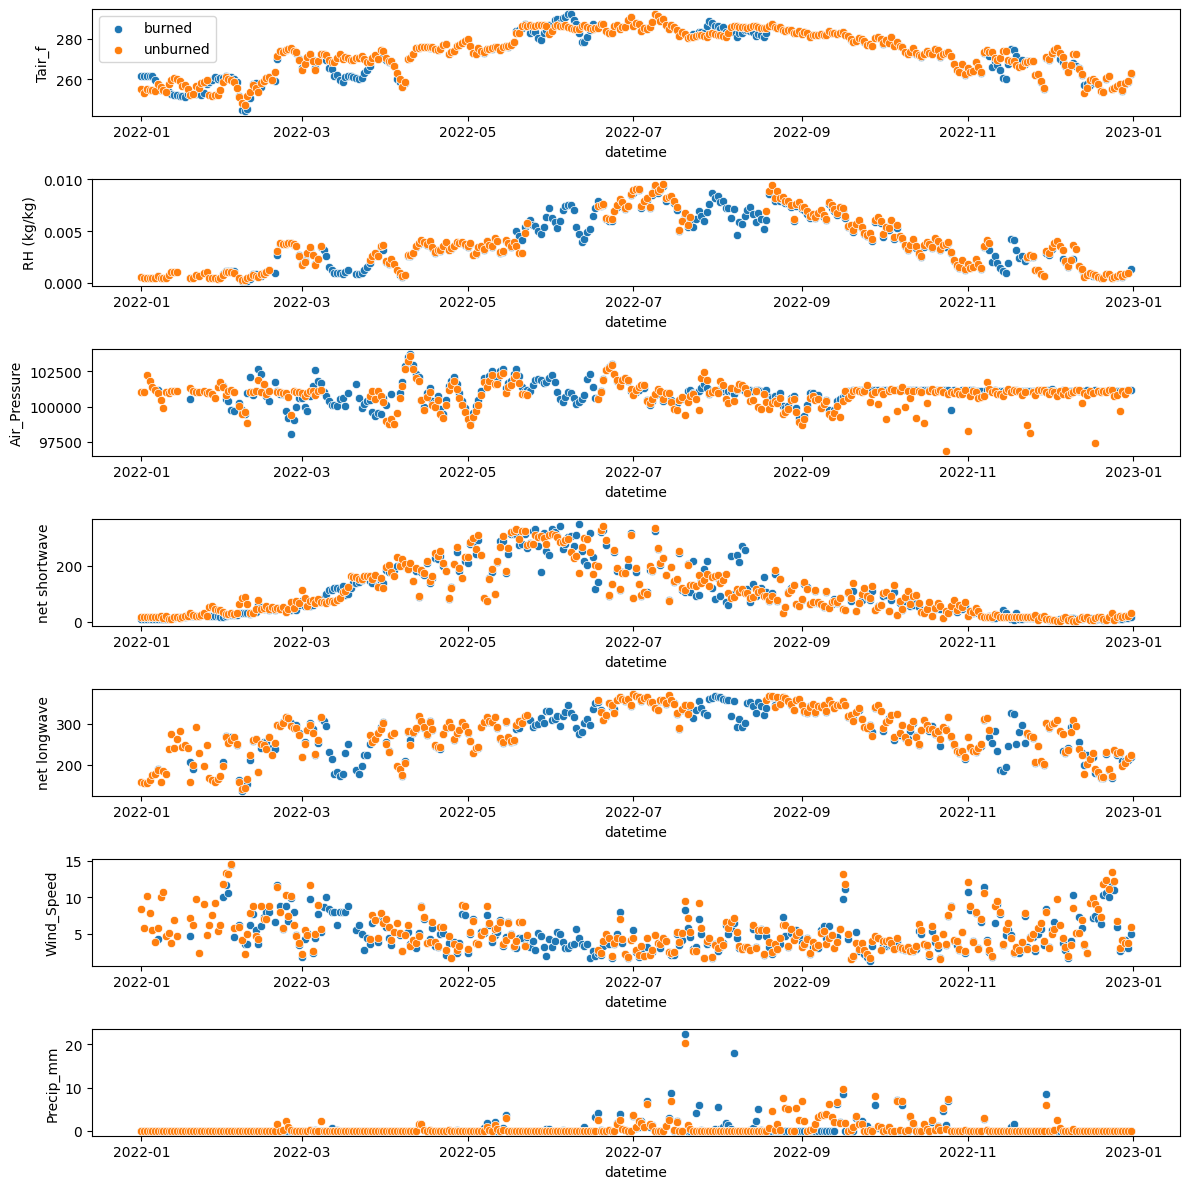

In [49]:
#plot initial data
fig, axes=plt.subplots(7,1, figsize=(12,12))
sns.scatterplot(data=df_burned_daily, x='datetime', y='Tair_f', ax=axes[0], label='burned')
sns.scatterplot(data=df_unburned_daily, x='datetime', y='Tair_f', ax=axes[0], label='unburned')

sns.scatterplot(data=df_burned_daily, x='datetime', y='RH (kg/kg)', ax=axes[1])
sns.scatterplot(data=df_unburned_daily, x='datetime', y='RH (kg/kg)', ax=axes[1])

sns.scatterplot(data=df_burned_daily, x='datetime', y='Air_Pressure', ax=axes[2])
sns.scatterplot(data=df_unburned_daily, x='datetime', y='Air_Pressure', ax=axes[2])

sns.scatterplot(data=df_burned_daily, x='datetime', y=df_burned_daily['SW_Net'], ax=axes[3])
sns.scatterplot(data=df_unburned_daily, x='datetime', y=df_unburned_daily['SW_Net'], ax=axes[3])
axes[3].set_ylabel('net shortwave')

sns.scatterplot(data=df_burned_daily, x='datetime', y=df_burned_daily['LW_Net'], ax=axes[4])
sns.scatterplot(data=df_unburned_daily, x='datetime', y=df_unburned_daily['LW_Net'], ax=axes[4])
axes[4].set_ylabel('net longwave')

sns.scatterplot(data=df_burned_daily, x='datetime', y='Wind_Speed', ax=axes[5])
sns.scatterplot(data=df_unburned_daily, x='datetime', y='Wind_Speed', ax=axes[5])

sns.scatterplot(data=df_burned_daily, x='datetime', y='Precip_mm', ax=axes[6])
sns.scatterplot(data=df_unburned_daily, x='datetime', y='Precip_mm', ax=axes[6])

fig.tight_layout()


In [50]:
df_burned_daily['Air_Pressure'].mean()

100986.74046234663

# Gap-filling
We will first gap-fill the burned and unburned towers based on each other's data, with a correction to account for the slight difference between conditions at each tower

In [51]:
#merge the burned and unburned dataframes on datetime
df_daily_merged = df_unburned_daily.merge(df_burned_daily, on='datetime', suffixes=('_unburned', '_burned'))

In [52]:
#drop any rows containing nan for regression
df_daily_merged_nonan = df_daily_merged.dropna(axis=0)

In [53]:
df_daily_merged_nonan.columns

Index(['Year_unburned', 'Month_unburned', 'Day_unburned', 'Tair_f_unburned',
       'RH_unburned', 'Wind_Speed_unburned', 'Wind_Dir_unburned',
       'SW_In_f_unburned', 'SW_Out_unburned', 'LW_In_unburned',
       'LW_Out_unburned', 'Precip_mm_unburned', 'Air_Pressure_unburned',
       'datetime', 'SW_Net_unburned', 'LW_Net_unburned', 'RH (kg/kg)_unburned',
       'Year_burned', 'Month_burned', 'Day_burned', 'Tair_f_burned',
       'RH_burned', 'Wind_Speed_burned', 'Wind_Dir_burned', 'SW_In_f_burned',
       'SW_Out_burned', 'LW_In_burned', 'LW_Out_burned', 'Precip_mm_burned',
       'Air_Pressure_burned', 'SW_Net_burned', 'LW_Net_burned',
       'RH (kg/kg)_burned'],
      dtype='object')

In [54]:
def get_correction_fit(df, from_column, to_column):
    """Applies linear regression bias-correct values from {from_column} to {to_column}

    Args:
        df (pd.DataFrame): dataframe containing columns to correct
        from_column (str): column with data which we wish to apply bias correction
        to_column (str): column with target data distribution

    Returns:
         reg_score (float): r2 score for linear regression
         reg_coef (float): coefficient for bias-correction linear regression
         reg_intercept (float): intercept for bias-correction linear regression
    """ 
    reg = LinearRegression().fit(df[from_column].to_numpy().reshape(-1,1), 
                                  df[to_column].to_numpy().reshape(-1,1))
    reg_score=reg.score(df[from_column].to_numpy().reshape(-1,1), 
                              df[to_column].to_numpy().reshape(-1,1))
    reg_coef=reg.coef_[0]
    reg_intercept=reg.intercept_[0]
    
    return reg_score, reg_coef, reg_intercept

In [55]:
#burned to unburned corrections
b2u_reg_tair_score, b2u_reg_tair_coef, b2u_reg_tair_intercept = get_correction_fit(df_daily_merged_nonan, 'Tair_f_burned', 'Tair_f_unburned')

b2u_reg_rh_score, b2u_reg_rh_coef, b2u_reg_rh_intercept = get_correction_fit(df_daily_merged_nonan, 'RH (kg/kg)_burned', 'RH (kg/kg)_unburned')

#air pressure contains some strange values, so we will just shift the distribution to align the median values
b2u_air_press_median_adjust = np.median(df_daily_merged_nonan['Air_Pressure_burned']) - np.median(df_daily_merged_nonan['Air_Pressure_unburned'])

b2u_reg_sw_net_score, b2u_reg_sw_net_coef, b2u_reg_sw_net_intercept = get_correction_fit(df_daily_merged_nonan, 'SW_Net_burned', 'SW_Net_unburned')

b2u_reg_lw_net_score, b2u_reg_lw_net_coef, b2u_reg_lw_net_intercept = get_correction_fit(df_daily_merged_nonan, 'LW_Net_burned', 'LW_Net_unburned')

b2u_reg_wind_speed_score, b2u_reg_wind_speed_coef, b2u_reg_wind_speed_intercept = get_correction_fit(df_daily_merged_nonan, 'Wind_Speed_burned', 'Wind_Speed_unburned')

#unburned to burned corrections
u2b_reg_tair_score, u2b_reg_tair_coef, u2b_reg_tair_intercept = get_correction_fit(df_daily_merged_nonan, 'Tair_f_unburned', 'Tair_f_burned')

u2b_reg_rh_score, u2b_reg_rh_coef, u2b_reg_rh_intercept = get_correction_fit(df_daily_merged_nonan, 'RH (kg/kg)_unburned', 'RH (kg/kg)_burned')

#air pressure contains some strange values, so we will just shift the distribution to align the median values
u2b_air_press_median_adjust = np.median(df_daily_merged_nonan['Air_Pressure_unburned']) - np.median(df_daily_merged_nonan['Air_Pressure_burned'])

u2b_reg_sw_net_score, u2b_reg_sw_net_coef, u2b_reg_sw_net_intercept = get_correction_fit(df_daily_merged_nonan, 'SW_Net_unburned', 'SW_Net_burned')

u2b_reg_lw_net_score, u2b_reg_lw_net_coef, u2b_reg_lw_net_intercept = get_correction_fit(df_daily_merged_nonan, 'LW_Net_unburned', 'LW_Net_burned')

u2b_reg_wind_speed_score, u2b_reg_wind_speed_coef, u2b_reg_wind_speed_intercept = get_correction_fit(df_daily_merged_nonan, 'Wind_Speed_unburned', 'Wind_Speed_burned')


<Axes: xlabel='Wind_Speed_unburned', ylabel='Wind_Speed_burned'>

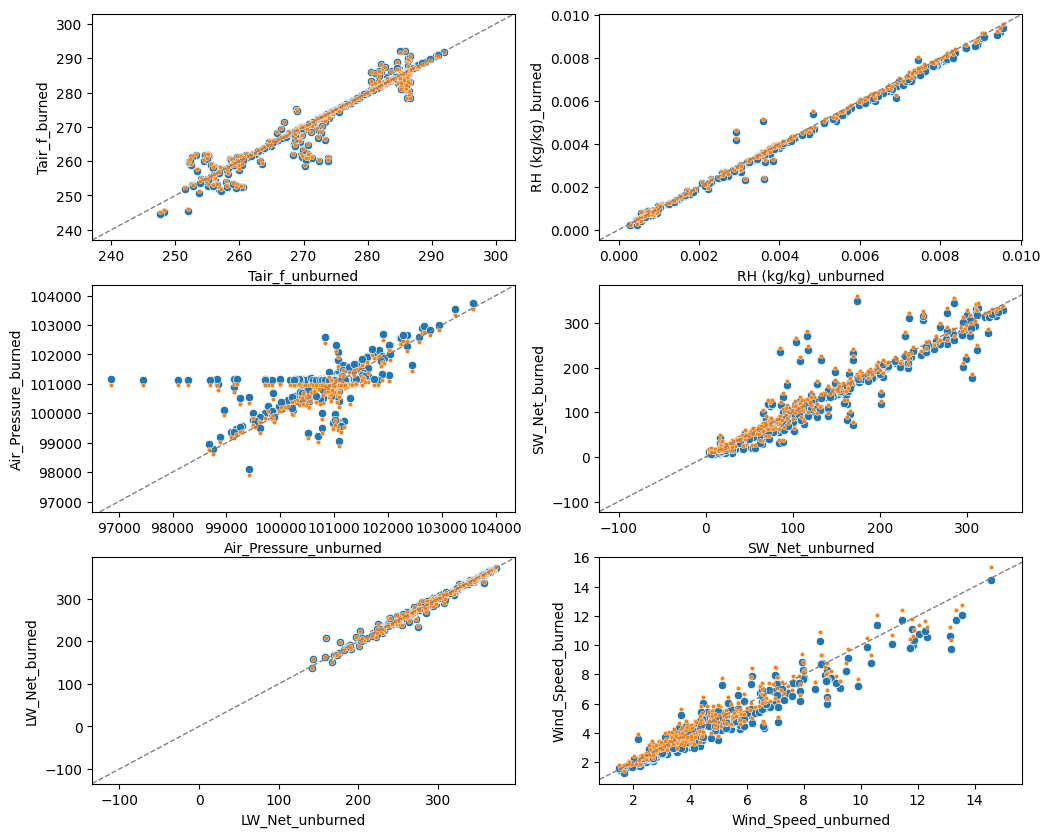

In [56]:
#plot relationship before and after bias correction

fig, axes=plt.subplots(3,2, figsize=(12,10))

axes[0,0].axline((240, 240), (300, 300), linewidth=1, color='grey', linestyle='--')
sns.scatterplot(data=df_daily_merged, x='Tair_f_unburned', y='Tair_f_burned', ax=axes[0,0])
sns.scatterplot(x=df_daily_merged['Tair_f_unburned'], y=df_daily_merged['Tair_f_burned']*b2u_reg_tair_coef+b2u_reg_tair_intercept, ax=axes[0,0],s=10)

axes[0,1].axline((0, 0), (0.001, 0.001), linewidth=1, color='grey', linestyle='--')
sns.scatterplot(data=df_daily_merged, x='RH (kg/kg)_unburned', y='RH (kg/kg)_burned', ax=axes[0,1])
sns.scatterplot(x=df_daily_merged['RH (kg/kg)_unburned'], y=df_daily_merged['RH (kg/kg)_burned']*b2u_reg_rh_coef+b2u_reg_rh_intercept, ax=axes[0,1],s=10)

axes[1,0].axline((97000, 97000), (104000, 104000), linewidth=1, color='grey', linestyle='--')
sns.scatterplot(data=df_daily_merged, x='Air_Pressure_unburned', y='Air_Pressure_burned', ax=axes[1,0])
sns.scatterplot(x=df_daily_merged['Air_Pressure_unburned'], y=df_daily_merged['Air_Pressure_burned']-b2u_air_press_median_adjust, ax=axes[1,0],s=10)


axes[1,1].axline((-100, -100), (260, 260), linewidth=1, color='grey', linestyle='--')
sns.scatterplot(data=df_daily_merged, x='SW_Net_unburned', y='SW_Net_burned', ax=axes[1,1])
sns.scatterplot(x=df_daily_merged['SW_Net_unburned'], y=df_daily_merged['SW_Net_burned']*b2u_reg_sw_net_coef+b2u_reg_sw_net_intercept, ax=axes[1,1],s=10)

axes[2,0].axline((-110, -110), (10, 10), linewidth=1, color='grey', linestyle='--')
sns.scatterplot(data=df_daily_merged, x='LW_Net_unburned', y='LW_Net_burned', ax=axes[2,0])
sns.scatterplot(x=df_daily_merged['LW_Net_unburned'], y=df_daily_merged['LW_Net_burned']*b2u_reg_lw_net_coef+b2u_reg_lw_net_intercept, ax=axes[2,0],s=10)

axes[2,1].axline((1.5, 1.5), (15, 15), linewidth=1, color='grey', linestyle='--')
sns.scatterplot(data=df_daily_merged, x='Wind_Speed_unburned', y='Wind_Speed_burned', ax=axes[2,1])
sns.scatterplot(x=df_daily_merged['Wind_Speed_unburned'], y=df_daily_merged['Wind_Speed_burned']*b2u_reg_wind_speed_coef+b2u_reg_wind_speed_intercept, ax=axes[2,1],s=10)



In [57]:
#filled unburned dataset
df_unburned_filled=pd.DataFrame()
df_unburned_filled['datetime'] = df_daily_merged['datetime']
df_unburned_filled['Year'] = df_daily_merged['Year_unburned']
df_unburned_filled['Month'] = df_daily_merged['Month_unburned']
df_unburned_filled['Day'] = df_daily_merged['Day_unburned']
df_unburned_filled['Tair_f'] = df_daily_merged['Tair_f_unburned']
df_unburned_filled['RH'] = df_daily_merged['RH (kg/kg)_unburned']
df_unburned_filled['Air_Pressure'] = df_daily_merged['Air_Pressure_unburned']
df_unburned_filled['SW_Net'] = df_daily_merged['SW_Net_unburned']
df_unburned_filled['LW_Net'] = df_daily_merged['LW_Net_unburned']
df_unburned_filled['Wind_Speed'] = df_daily_merged['Wind_Speed_unburned']
df_unburned_filled['Wind_Dir'] = df_daily_merged['Wind_Dir_unburned']
df_unburned_filled['Precip_mm'] = df_daily_merged['Precip_mm_unburned']

#filled burned dataset
df_burned_filled=pd.DataFrame()
df_burned_filled['datetime'] = df_daily_merged['datetime']
df_burned_filled['Year'] = df_daily_merged['Year_burned']
df_burned_filled['Month'] = df_daily_merged['Month_burned']
df_burned_filled['Day'] = df_daily_merged['Day_burned']
df_burned_filled['Tair_f'] = df_daily_merged['Tair_f_burned']
df_burned_filled['RH'] = df_daily_merged['RH (kg/kg)_burned']
df_burned_filled['Air_Pressure'] = df_daily_merged['Air_Pressure_burned']
df_burned_filled['SW_Net'] = df_daily_merged['SW_Net_burned']
df_burned_filled['LW_Net'] = df_daily_merged['LW_Net_burned']
df_burned_filled['Wind_Speed'] = df_daily_merged['Wind_Speed_burned']
df_burned_filled['Wind_Dir'] = df_daily_merged['Wind_Dir_burned']
df_burned_filled['Precip_mm'] = df_daily_merged['Precip_mm_burned']

In [58]:
#fill unburned dataset
df_unburned_filled.loc[df_unburned_filled['RH'].isnull(),'RH'] = df_daily_merged.loc[df_daily_merged['RH (kg/kg)_unburned'].isnull(),'RH (kg/kg)_burned']*b2u_reg_rh_coef+b2u_reg_rh_intercept
df_unburned_filled['RH']=df_unburned_filled['RH'].interpolate()

df_unburned_filled.loc[df_unburned_filled['Air_Pressure'].isnull(),'Air_Pressure'] = df_daily_merged.loc[df_daily_merged['Air_Pressure_unburned'].isnull(),'Air_Pressure_burned']-b2u_air_press_median_adjust
df_unburned_filled['Air_Pressure']=df_unburned_filled['Air_Pressure'].interpolate()

df_unburned_filled.loc[df_unburned_filled['SW_Net'].isnull(),'SW_Net'] = df_daily_merged.loc[df_daily_merged['SW_Net_unburned'].isnull(),'SW_Net_burned']*b2u_reg_sw_net_coef+b2u_reg_sw_net_intercept
df_unburned_filled['SW_Net']=df_unburned_filled['SW_Net'].interpolate()

df_unburned_filled.loc[df_unburned_filled['LW_Net'].isnull(),'LW_Net'] = df_daily_merged.loc[df_daily_merged['LW_Net_unburned'].isnull(),'LW_Net_burned']*b2u_reg_lw_net_coef+b2u_reg_lw_net_intercept
df_unburned_filled['LW_Net']=df_unburned_filled['LW_Net'].interpolate()

df_unburned_filled.loc[df_unburned_filled['Wind_Speed'].isnull(),'Wind_Speed'] = df_daily_merged.loc[df_daily_merged['Wind_Speed_unburned'].isnull(),'Wind_Speed_burned']*b2u_reg_wind_speed_coef+b2u_reg_wind_speed_intercept
df_unburned_filled['Wind_Speed']=df_unburned_filled['Wind_Speed'].interpolate()

df_unburned_filled.loc[df_unburned_filled['Wind_Dir'].isnull(),'Wind_Dir'] = df_daily_merged.loc[df_daily_merged['Wind_Dir_unburned'].isnull(),'Wind_Dir_burned']
df_unburned_filled['Wind_Dir']=df_unburned_filled['Wind_Dir'].interpolate()

#fill burned dataset
df_burned_filled.loc[df_burned_filled['RH'].isnull(),'RH'] = df_daily_merged.loc[df_daily_merged['RH (kg/kg)_burned'].isnull(),'RH (kg/kg)_unburned']*u2b_reg_rh_coef+u2b_reg_rh_intercept
df_burned_filled['RH']=df_burned_filled['RH'].interpolate()

df_burned_filled.loc[df_burned_filled['Air_Pressure'].isnull(),'Air_Pressure'] = df_daily_merged.loc[df_daily_merged['Air_Pressure_burned'].isnull(),'Air_Pressure_unburned']-u2b_air_press_median_adjust
df_burned_filled['Air_Pressure']=df_burned_filled['Air_Pressure'].interpolate()

df_burned_filled.loc[df_burned_filled['SW_Net'].isnull(),'SW_Net'] = df_daily_merged.loc[df_daily_merged['SW_Net_burned'].isnull(),'SW_Net_unburned']*u2b_reg_sw_net_coef+u2b_reg_sw_net_intercept
df_burned_filled['SW_Net']=df_burned_filled['SW_Net'].interpolate()

df_burned_filled.loc[df_burned_filled['LW_Net'].isnull(),'LW_Net'] = df_daily_merged.loc[df_daily_merged['LW_Net_burned'].isnull(),'LW_Net_unburned']*u2b_reg_lw_net_coef+u2b_reg_lw_net_intercept
df_burned_filled['LW_Net']=df_burned_filled['LW_Net'].interpolate()

df_burned_filled.loc[df_burned_filled['Wind_Speed'].isnull(),'Wind_Speed'] = df_daily_merged.loc[df_daily_merged['Wind_Speed_burned'].isnull(),'Wind_Speed_unburned']*u2b_reg_wind_speed_coef+u2b_reg_wind_speed_intercept
df_burned_filled['Wind_Speed']=df_burned_filled['Wind_Speed'].interpolate()

df_burned_filled.loc[df_burned_filled['Wind_Dir'].isnull(),'Wind_Dir'] = df_daily_merged.loc[df_daily_merged['Wind_Dir_burned'].isnull(),'Wind_Dir_unburned']
df_burned_filled['Wind_Dir']=df_burned_filled['Wind_Dir'].interpolate()

df_unburned_filled.loc[df_unburned_filled['Precip_mm'].isnull(),'Precip_mm'] = 0
df_burned_filled.loc[df_burned_filled['Precip_mm'].isnull(),'Precip_mm'] = 0
df_burned_filled.loc[df_burned_filled['Precip_mm']==0,'Precip_mm'] = df_unburned_filled.loc[df_burned_filled['Precip_mm']==0,'Precip_mm']
df_unburned_filled.loc[df_unburned_filled['Precip_mm']==0,'Precip_mm'] = df_burned_filled.loc[df_unburned_filled['Precip_mm']==0,'Precip_mm']

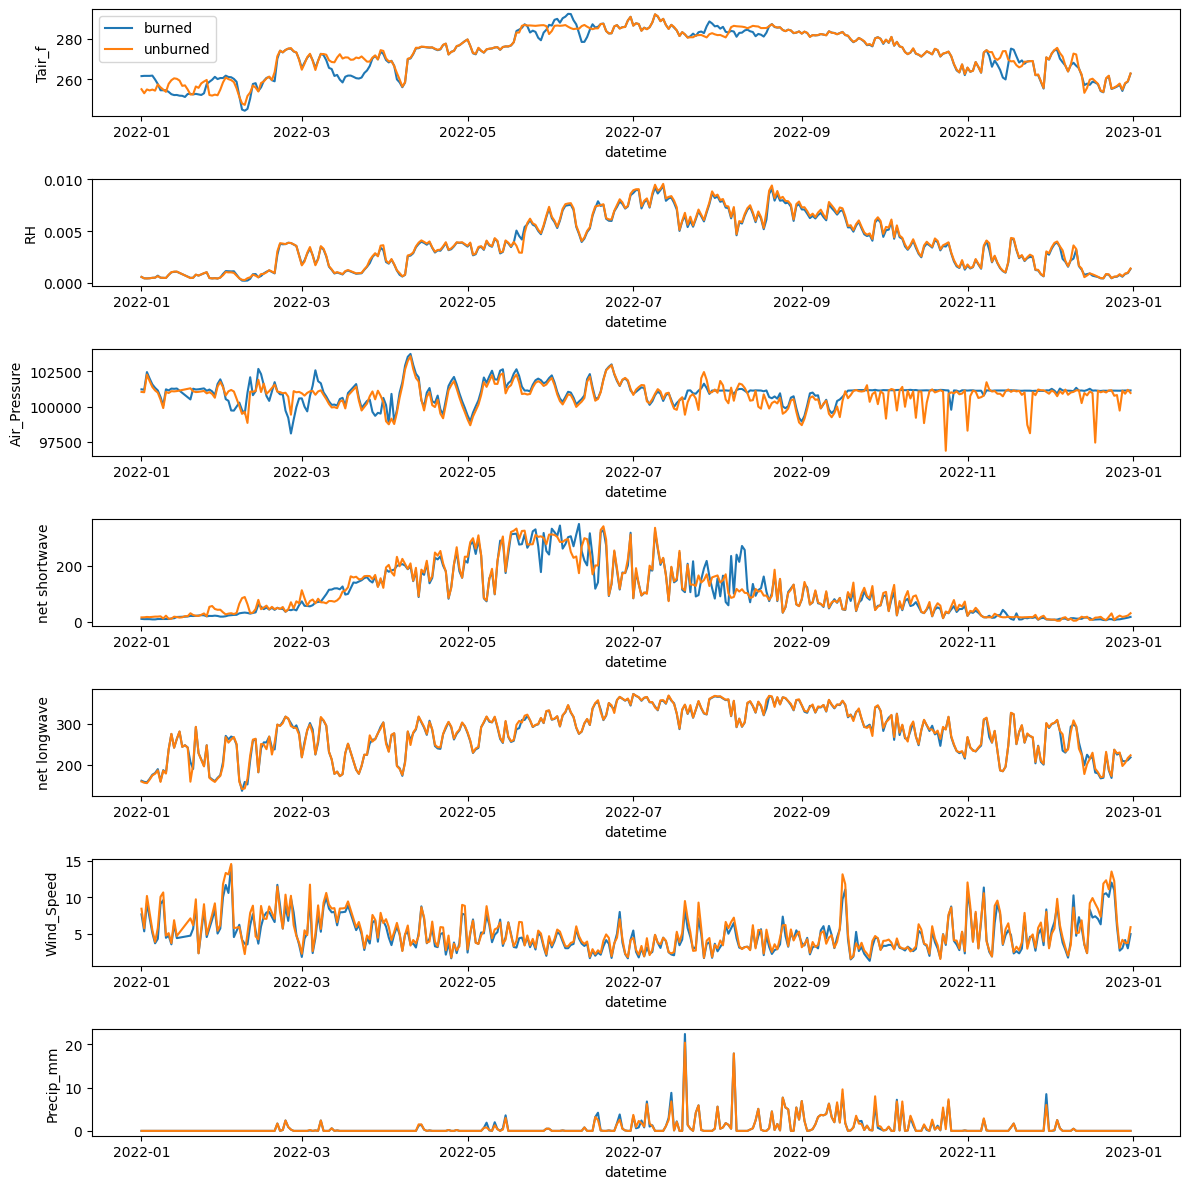

In [59]:
#plot gap-filled dataset
fig, axes=plt.subplots(7,1, figsize=(12,12))

sns.lineplot(data=df_burned_filled, x='datetime', y='Tair_f', ax=axes[0], label='burned')
sns.lineplot(data=df_unburned_filled, x='datetime', y='Tair_f', ax=axes[0], label='unburned')

sns.lineplot(data=df_burned_filled, x='datetime', y='RH', ax=axes[1])
sns.lineplot(data=df_unburned_filled, x='datetime', y='RH', ax=axes[1])

sns.lineplot(data=df_burned_filled, x='datetime', y='Air_Pressure', ax=axes[2])
sns.lineplot(data=df_unburned_filled, x='datetime', y='Air_Pressure', ax=axes[2])

sns.lineplot(data=df_burned_filled, x='datetime', y=df_burned_filled['SW_Net'], ax=axes[3])
sns.lineplot(data=df_unburned_filled, x='datetime', y=df_unburned_filled['SW_Net'], ax=axes[3])
axes[3].set_ylabel('net shortwave')

sns.lineplot(data=df_burned_filled, x='datetime', y=df_burned_filled['LW_Net'], ax=axes[4])
sns.lineplot(data=df_unburned_filled, x='datetime', y=df_unburned_filled['LW_Net'], ax=axes[4])
axes[4].set_ylabel('net longwave')

sns.lineplot(data=df_burned_filled, x='datetime', y='Wind_Speed', ax=axes[5])
sns.lineplot(data=df_unburned_filled, x='datetime', y='Wind_Speed', ax=axes[5])

sns.lineplot(data=df_burned_filled, x='datetime', y='Precip_mm', ax=axes[6])
sns.lineplot(data=df_unburned_filled, x='datetime', y='Precip_mm', ax=axes[6])

fig.tight_layout()

# Check for nans in inputs

In [60]:
len(df_unburned_filled)

365

In [61]:
len(df_unburned_filled.dropna(axis=0))

365

In [62]:
len(df_burned_filled)

365

In [63]:
len(df_burned_filled.dropna(axis=0))

365

# Add snow information

In [64]:
snotel_path= 'raw/McGrath_SNOTEL_2022.csv'
snow_df=pd.read_csv(snotel_path,skiprows=4)
snow_df=snow_df.rename(columns={'Date': 'datetime'})
snow_df['datetime'] = pd.to_datetime(snow_df['datetime'])
snow_df.columns

snow_df['WTEQ.I-1 (in) '] = snow_df['WTEQ.I-1 (in) ']/2 #We need to reduce SWE since the met obs are coming from a site with deeper snowpack

snow_df['SWE (mm)'] = snow_df['WTEQ.I-1 (in) '] * 25.4 #in to mm
snow_df.loc[snow_df['SWE (mm)']<0, 'SWE (mm)']=0 #filter negative SWE
snow_df=snow_df[['datetime', 'SWE (mm)']]
snow_df=snow_df.sort_values(by='datetime')
snow_df['SWE_diff'] = snow_df['SWE (mm)'].diff() #calculate change in SWE
snow_df.loc[0, 'SWE_diff'] = 0
snow_df['SWE_accum'] = 0
snow_df.loc[snow_df['SWE_diff']>0, 'SWE_accum'] = snow_df['SWE_diff'] #filter out negative change in SWE

<Axes: xlabel='datetime', ylabel='SWE_accum'>

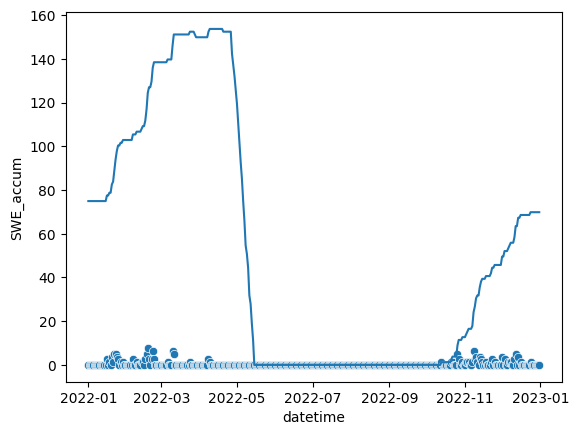

In [65]:
sns.scatterplot(data=snow_df, x='datetime', y='SWE_accum')
sns.lineplot(data=snow_df, x='datetime', y='SWE (mm)')


In [66]:
#merge SWE accumulation
df_unburned_filled = df_unburned_filled.merge(snow_df[['datetime', 'SWE_accum']], on='datetime')
df_burned_filled = df_burned_filled.merge(snow_df[['datetime', 'SWE_accum']], on='datetime')

## Experiment: zero snowfall

In [67]:
#set snow accumulation to zero
#df_unburned_filled['SWE_accum'] = 0
#df_burned_filled['SWE_accum'] = 0

In [ ]:
## Add SWE to rainfall, convert to precip intensity

In [68]:
#add SWE to precip
df_unburned_filled['Precip_mm'] = df_unburned_filled['Precip_mm']+df_unburned_filled['SWE_accum']
df_burned_filled['Precip_mm'] = df_burned_filled['Precip_mm']+df_burned_filled['SWE_accum']

In [69]:
#convert precip (mm/day) to (m/s)
df_unburned_filled['Precip_intensity_ms-1'] = (df_unburned_filled['Precip_mm']/1000)/86400
df_burned_filled['Precip_intensity_ms-1'] = (df_burned_filled['Precip_mm']/1000)/86400

# Smooth variables

In [70]:
def smooth_timeseries(df,w):
    df1=df.copy()
    df1["Tair_f"] = scipy.signal.savgol_filter(df1["Tair_f"], w, 2, mode='wrap')
    df1["LW_Net"] = scipy.signal.savgol_filter(df1["LW_Net"], w, 2, mode='wrap')
    df1["SW_Net"] = scipy.signal.savgol_filter(df1["SW_Net"], w, 2, mode='wrap')
    df1["Wind_Speed"] = scipy.signal.savgol_filter(df1["Wind_Speed"], w, 2, mode='wrap')
    df1["Air_Pressure"] = scipy.signal.medfilt(df1["Air_Pressure"], 15)
    #m_precip_rain = df1["rain [m/s]"].mean()
    #m_precip_snow = df1["snow [m/s]"].mean()
    #snow = np.where(df1["Temp [K]"] < 273.15, m_precip_snow, 0)
    #rain = np.where(df1["Temp [K]"] >= 273.15, m_precip_rain, 0)
    #df1["rain [m/s]"] = rain
    #df1["snow [m/s]"] = snow

    return df1

In [71]:
df_unburned_filled=smooth_timeseries(df_unburned_filled, 5)
df_burned_filled=smooth_timeseries(df_burned_filled, 5)

# Split wind speed into U and V components

In [72]:
pi_180= np.pi/180

df_unburned_filled.loc[df_unburned_filled['Wind_Dir']==360, 'Wind_Dir'] = 0
df_burned_filled.loc[df_burned_filled['Wind_Dir']==360, 'Wind_Dir'] = 0

df_unburned_filled['Wind_Speed_u'] = -df_unburned_filled['Wind_Speed']*np.cos(df_unburned_filled['Wind_Dir']*pi_180)
df_unburned_filled['Wind_Speed_v'] = -df_unburned_filled['Wind_Speed']*np.sin(df_unburned_filled['Wind_Dir']*pi_180)

df_burned_filled['Wind_Speed_u'] = -df_burned_filled['Wind_Speed']*np.cos(df_burned_filled['Wind_Dir']*pi_180)
df_burned_filled['Wind_Speed_v'] = -df_burned_filled['Wind_Speed']*np.sin(df_burned_filled['Wind_Dir']*pi_180)

df_unburned_filled.loc[df_unburned_filled['Wind_Speed_u'].abs()<0.1, 'Wind_Speed_u'] = 0
df_unburned_filled.loc[df_unburned_filled['Wind_Speed_v'].abs()<0.1, 'Wind_Speed_u'] = 0

df_burned_filled.loc[df_burned_filled['Wind_Speed_u'].abs()<0.1, 'Wind_Speed_u'] = 0
df_burned_filled.loc[df_burned_filled['Wind_Speed_v'].abs()<0.1, 'Wind_Speed_u'] = 0

## Experiment: Tair * 1.2

In [73]:
#df_burned_filled['Tair_f'] = df_burned_filled['Tair_f'] * 1.2
#df_unburned_filled['Tair_f'] = df_unburned_filled['Tair_f'] * 1.2

# Plot final data, format for LAKE input

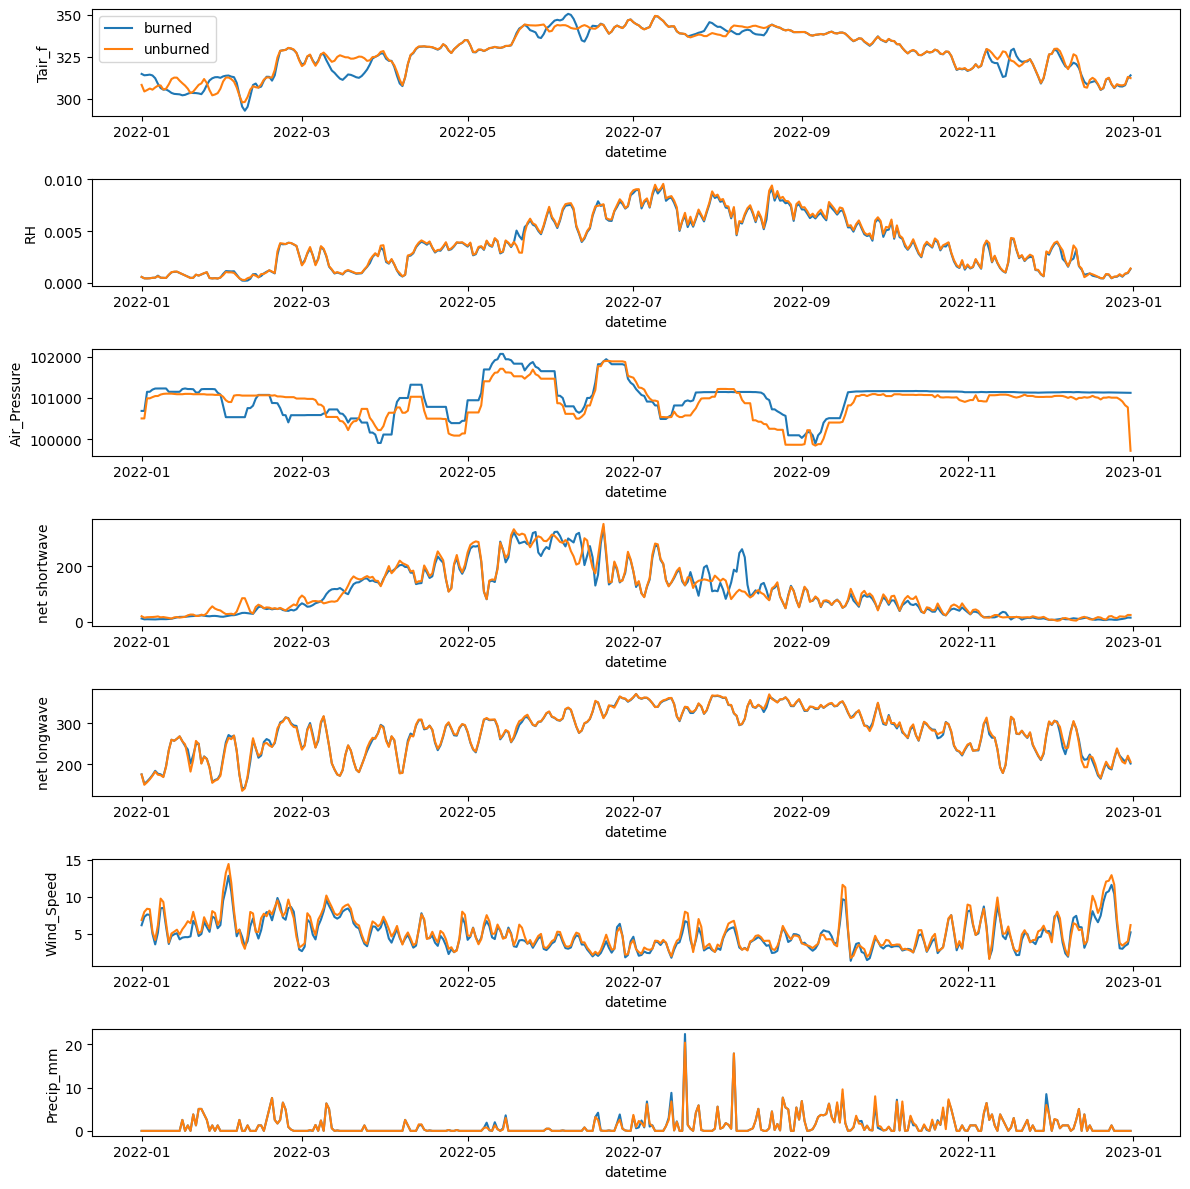

In [74]:
fig, axes=plt.subplots(7,1, figsize=(12,12))

sns.lineplot(data=df_burned_filled, x='datetime', y='Tair_f', ax=axes[0], label='burned')
sns.lineplot(data=df_unburned_filled, x='datetime', y='Tair_f', ax=axes[0], label='unburned')

sns.lineplot(data=df_burned_filled, x='datetime', y='RH', ax=axes[1])
sns.lineplot(data=df_unburned_filled, x='datetime', y='RH', ax=axes[1])

sns.lineplot(data=df_burned_filled, x='datetime', y='Air_Pressure', ax=axes[2])
sns.lineplot(data=df_unburned_filled, x='datetime', y='Air_Pressure', ax=axes[2])

sns.lineplot(data=df_burned_filled, x='datetime', y='SW_Net', ax=axes[3])
sns.lineplot(data=df_unburned_filled, x='datetime', y='SW_Net', ax=axes[3])
axes[3].set_ylabel('net shortwave')

sns.lineplot(data=df_burned_filled, x='datetime', y='LW_Net', ax=axes[4])
sns.lineplot(data=df_unburned_filled, x='datetime', y='LW_Net', ax=axes[4])
axes[4].set_ylabel('net longwave')

sns.lineplot(data=df_burned_filled, x='datetime', y='Wind_Speed', ax=axes[5])
sns.lineplot(data=df_unburned_filled, x='datetime', y='Wind_Speed', ax=axes[5])

sns.lineplot(data=df_burned_filled, x='datetime', y='Precip_mm', ax=axes[6])
sns.lineplot(data=df_unburned_filled, x='datetime', y='Precip_mm', ax=axes[6])

fig.tight_layout()
plt.savefig('LAKE_ins_YKD_2022.jpg', dpi=300)

In [75]:
#TODO
#smooth air pressure
#smooth precip

### LAKE Parameters again for reference

* N_header_lines* --- the number of lines, occupied by file header 
* N_coloumns*     --- the total number of coloumns in the file
* N_Year*         --- the number of coloumn with the number of year (not used in the model)
* N_Month*        --- the number of coloumn with the number of month (not used in the model)
* N_Day*          --- the number of coloumn with the number of day (not used in the model)
* N_Hour*         --- the number of coloumn with the number of hour (not used in the model)
* N_Uspeed*       --- the number of coloumn with x-component speed values,      (m/s)
* N_Vspeed*       --- the number of coloumn with y-component speed values,      (m/s)
* N_Temp*         --- the number of coloumn with air temperature values,        (K)
* N_Hum*          --- the number of coloumn with air humidity values,           (kg/kg)
* N_Pres*         --- the number of coloumn with atmospheric pressure value,s   (Pa)
* N_SWdown*       --- the number of coloumn with net solar radiation values,    (W/m**2)
* N_LWdown*       --- the number of coloumn with net longwave radiation values, (W/m**2)
* N_Precip*       --- the number of coloumn with precipitation intensity,       (m/s)

In [77]:
df_burned_out=df_burned_filled[['Year', 'Month', 'Day', 'Wind_Speed_u', 'Wind_Speed_v',
                                'Tair_f', 'RH', 'Air_Pressure', 'SW_Net', 'LW_Net', 'Precip_intensity_ms-1']]
df_burned_out.columns=['Year','Month','Day','Uspeed','Vspeed','Temp','Hum','Pres','SWdown','LWdown','Precip']

df_unburned_out=df_unburned_filled[['Year', 'Month', 'Day', 'Wind_Speed_u', 'Wind_Speed_v',
                                'Tair_f', 'RH', 'Air_Pressure', 'SW_Net', 'LW_Net', 'Precip_intensity_ms-1']]
df_unburned_out.columns=['Year','Month','Day','Uspeed','Vspeed','Temp','Hum','Pres','SWdown','LWdown','Precip']

In [78]:
#df_unburned_out.to_csv('prepped/YKD-unburned-no-snow.dat', index=False)
#df_burned_out.to_csv('prepped/YKD-burned-no-snow.dat', index=False)

#df_unburned_out.to_csv('prepped/YKD-unburned-tplus20pct.dat', index=False)
#df_burned_out.to_csv('prepped/YKD-burned-tplus20pct.dat', index=False)

df_unburned_out.to_csv('prepped/YKD-unburned.dat', index=False)
df_burned_out.to_csv('prepped/YKD-burned.dat', index=False)

In [95]:
df_unburned_8y = pd.concat([df_unburned_out]*8, ignore_index=True)
daterange=pd.date_range(start='2015-01-01', end='2022-12-31')
df_unburned_8y['datetime'] = daterange[(daterange.month != 2) | (daterange.day != 29)] #exclude leap days
df_unburned_8y['Year'] = df_unburned_8y['datetime'].dt.year
df_unburned_8y['Month'] = df_unburned_8y['datetime'].dt.month
df_unburned_8y['Day'] = df_unburned_8y['datetime'].dt.day
df_unburned_8y = df_unburned_8y.drop(columns=['datetime'])

In [96]:
#len(df_burned_8y)

In [97]:
df_burned_8y = pd.concat([df_burned_out]*8, ignore_index=True)
daterange=pd.date_range(start='2015-01-01', end='2022-12-31')
df_burned_8y['datetime'] = daterange[(daterange.month != 2) | (daterange.day != 29)] #exclude leap days
df_burned_8y['Year'] = df_burned_8y['datetime'].dt.year
df_burned_8y['Month'] = df_burned_8y['datetime'].dt.month
df_burned_8y['Day'] = df_burned_8y['datetime'].dt.day
df_burned_8y = df_burned_8y.drop(columns=['datetime'])

In [98]:
df_unburned_8y.to_csv('prepped/YKD-unburned-8y.dat', index=False)
df_burned_8y.to_csv('prepped/YKD-burned-8y.dat', index=False)

# Spinup dataset

In [99]:
#get Oct 1 - end of da

In [100]:
df_unburned_spinup_h1 = df_unburned_out.loc[df_unburned_out['Month']>=10]
df_unburned_spinup_h2 = df_unburned_out.loc[df_unburned_out['Month']<10]
df_unburned_spinup = pd.concat([df_unburned_spinup_h1,df_unburned_spinup_h2])
df_unburned_spinup = pd.concat([df_unburned_spinup]*40, ignore_index=True)
daterange=pd.date_range(start='1975-10-01', end='2015-09-30')
print(len(df_unburned_spinup))
df_unburned_spinup['datetime'] = daterange[(daterange.month != 2) | (daterange.day != 29)] #exclude leap days
print(len(df_unburned_spinup))

14600
14600


In [101]:
df_burned_spinup_h1 = df_burned_out.loc[df_burned_out['Month']>=10]
df_burned_spinup_h2 = df_burned_out.loc[df_burned_out['Month']<10]
df_burned_spinup = pd.concat([df_burned_spinup_h1,df_burned_spinup_h2])
df_burned_spinup = pd.concat([df_burned_spinup]*40, ignore_index=True)
daterange=pd.date_range(start='1975-10-01', end='2015-09-30')
df_burned_spinup['datetime'] = daterange[(daterange.month != 2) | (daterange.day != 29)] #exclude leap days

In [102]:
def smooth_spinup(df,w):
    df1=df.copy()
    df1["Temp"] = scipy.signal.savgol_filter(df1["Temp"], w, 2, mode='wrap')
    df1["LWdown"] = scipy.signal.savgol_filter(df1["LWdown"], w, 2, mode='wrap')
    df1["SWdown"] = scipy.signal.savgol_filter(df1["SWdown"], w, 2, mode='wrap')
    df1["Uspeed"] = scipy.signal.savgol_filter(df1["Uspeed"], w, 2, mode='wrap')
    df1["Vspeed"] = scipy.signal.savgol_filter(df1["Vspeed"], w, 2, mode='wrap')
    df1["Hum"] = scipy.signal.savgol_filter(df1["Hum"], w, 2, mode='wrap')
    df1["Pres"] = scipy.signal.medfilt(df1["Pres"], w)
    
    df1.loc[df1["Temp"] >= 273.15,"Precip"] = df1.loc[df1["Temp"] >= 273.15,"Precip"].mean()
    df1.loc[df1["Temp"] < 273.15,"Precip"] = df1.loc[df1["Temp"] < 273.15,"Precip"].mean()

    

    return df1

In [103]:
df_unburned_spinup_smoothed=smooth_spinup(df_unburned_spinup,25)
df_burned_spinup_smoothed=smooth_spinup(df_burned_spinup,25)

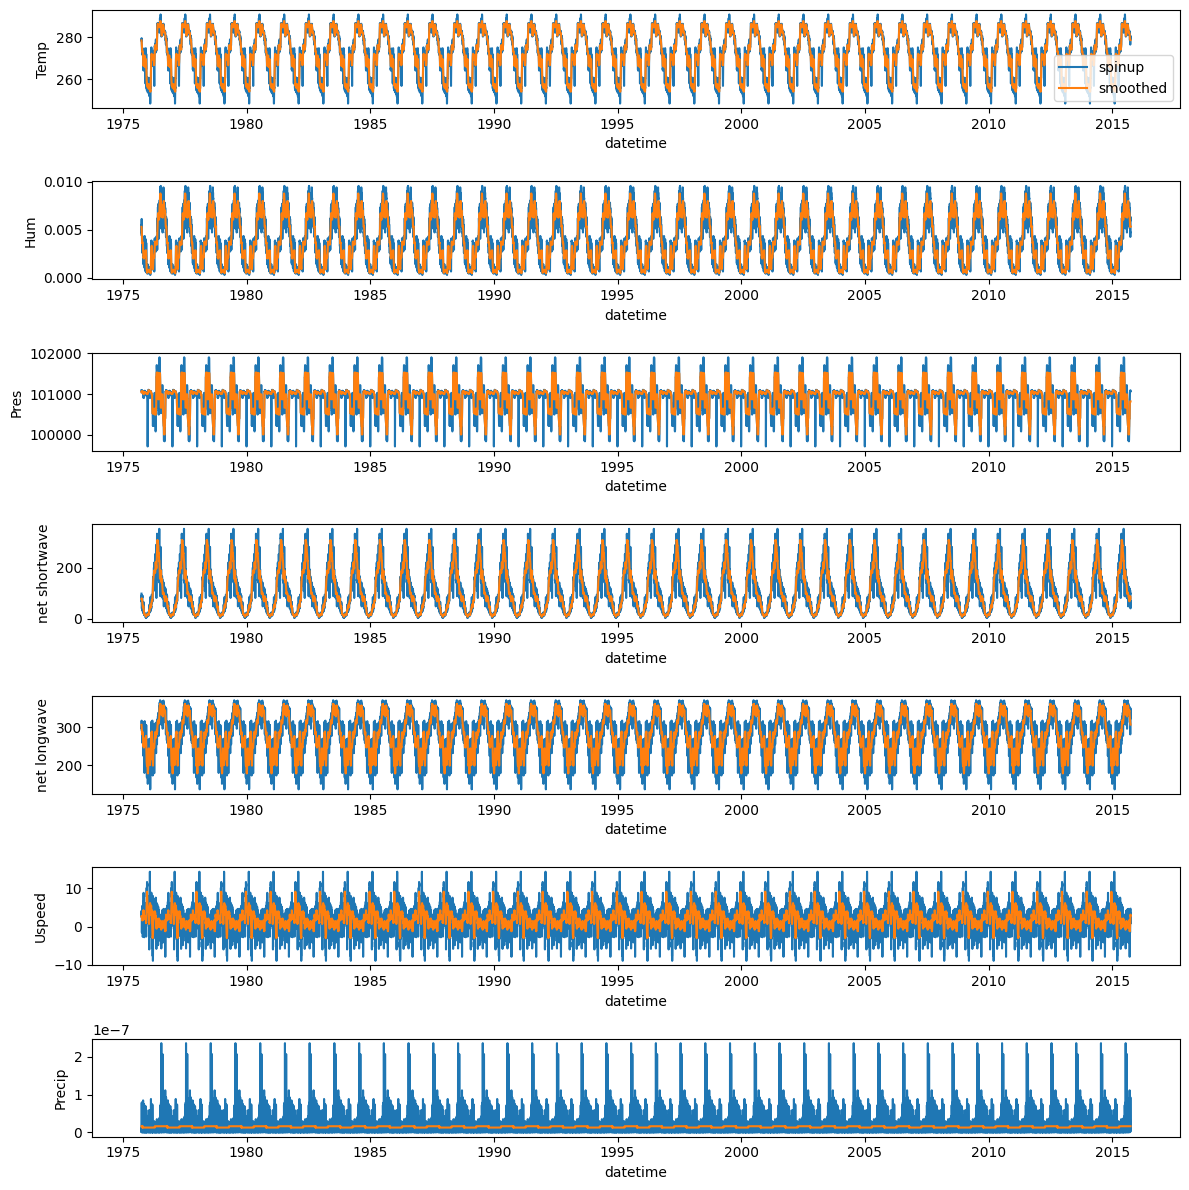

In [104]:
fig, axes=plt.subplots(7,1, figsize=(12,12))

sns.lineplot(data=df_unburned_spinup, x='datetime', y='Temp', ax=axes[0], label='spinup')
sns.lineplot(data=df_unburned_spinup_smoothed, x='datetime', y='Temp', ax=axes[0], label='smoothed')

sns.lineplot(data=df_unburned_spinup, x='datetime', y='Hum', ax=axes[1])
sns.lineplot(data=df_unburned_spinup_smoothed, x='datetime', y='Hum', ax=axes[1])

sns.lineplot(data=df_unburned_spinup, x='datetime', y='Pres', ax=axes[2])
sns.lineplot(data=df_unburned_spinup_smoothed, x='datetime', y='Pres', ax=axes[2])

sns.lineplot(data=df_unburned_spinup, x='datetime', y=df_unburned_spinup['SWdown'], ax=axes[3])
sns.lineplot(data=df_unburned_spinup_smoothed, x='datetime', y=df_unburned_spinup_smoothed['SWdown'], ax=axes[3])
axes[3].set_ylabel('net shortwave')

sns.lineplot(data=df_unburned_spinup, x='datetime', y=df_unburned_spinup['LWdown'], ax=axes[4])
sns.lineplot(data=df_unburned_spinup_smoothed, x='datetime', y=df_unburned_spinup_smoothed['LWdown'], ax=axes[4])
axes[4].set_ylabel('net longwave')

sns.lineplot(data=df_unburned_spinup, x='datetime', y='Uspeed', ax=axes[5])
sns.lineplot(data=df_unburned_spinup_smoothed, x='datetime', y='Uspeed', ax=axes[5])

sns.lineplot(data=df_unburned_spinup, x='datetime', y='Precip', ax=axes[6])
sns.lineplot(data=df_unburned_spinup_smoothed, x='datetime', y='Precip', ax=axes[6])

fig.tight_layout()
plt.savefig('Spinup_ins_YKD_unburned_2022.jpg', dpi=300)

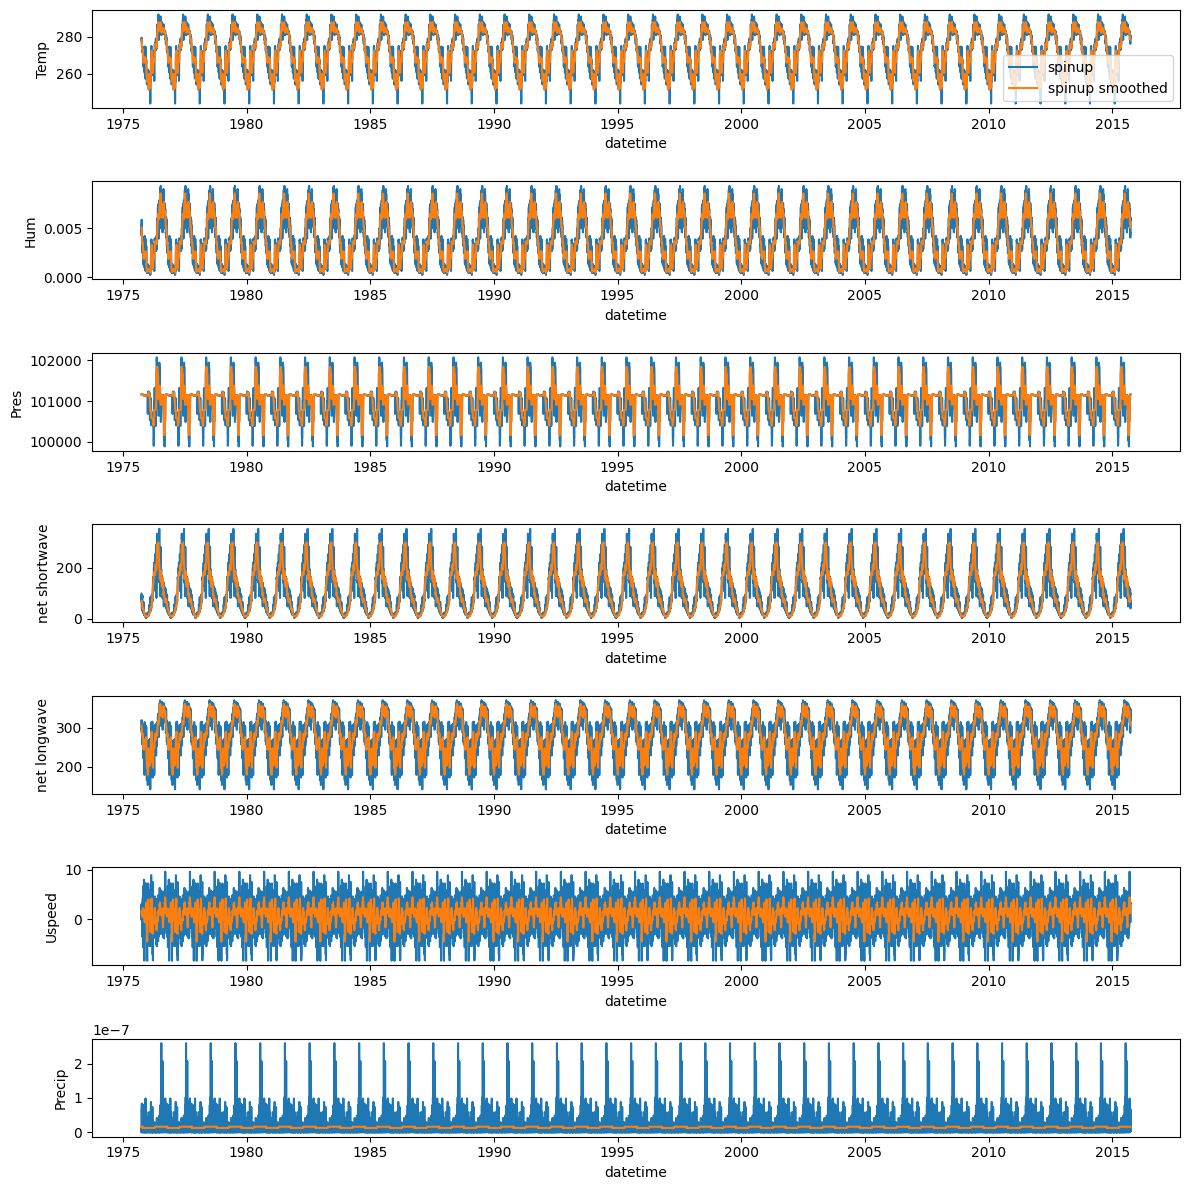

In [105]:
fig, axes=plt.subplots(7,1, figsize=(12,12))
spin_time = df_burned_spinup#[(df_burned_spinup['datetime']<'2001-01-01')&(df_burned_spinup['datetime']>='2000-11-01')]
smooth_time = df_burned_spinup_smoothed#[(df_burned_spinup_smoothed['datetime']<'2001-01-01')&(df_burned_spinup_smoothed['datetime']>='2000-11-01')]

sns.lineplot(data=spin_time, x='datetime', y='Temp', ax=axes[0], label='spinup')
sns.lineplot(data=smooth_time, x='datetime', y='Temp', ax=axes[0], label='spinup smoothed')

sns.lineplot(data=spin_time, x='datetime', y='Hum', ax=axes[1])
sns.lineplot(data=smooth_time, x='datetime', y='Hum', ax=axes[1])

sns.lineplot(data=spin_time, x='datetime', y='Pres', ax=axes[2])
sns.lineplot(data=smooth_time, x='datetime', y='Pres', ax=axes[2])

sns.lineplot(data=spin_time, x='datetime', y=df_unburned_spinup['SWdown'], ax=axes[3])
sns.lineplot(data=smooth_time, x='datetime', y=df_burned_spinup_smoothed['SWdown'], ax=axes[3])
axes[3].set_ylabel('net shortwave')

sns.lineplot(data=spin_time, x='datetime', y=df_burned_spinup['LWdown'], ax=axes[4])
sns.lineplot(data=smooth_time, x='datetime', y=df_burned_spinup_smoothed['LWdown'], ax=axes[4])
axes[4].set_ylabel('net longwave')

sns.lineplot(data=spin_time, x='datetime', y='Uspeed', ax=axes[5])
sns.lineplot(data=smooth_time, x='datetime', y='Uspeed', ax=axes[5])

sns.lineplot(data=spin_time, x='datetime', y='Precip', ax=axes[6])
sns.lineplot(data=smooth_time, x='datetime', y='Precip', ax=axes[6])

fig.tight_layout()
plt.savefig('Spinup_ins_YKD_burned_2000.jpg', dpi=300)

In [106]:
df_burned_spinup_smoothed.head()

,Year,Month,Day,Uspeed,Vspeed,Temp,Hum,Pres,SWdown,LWdown,Precip,datetime
0,2022,10,1,1.542644,-0.951886,278.480955,0.005103,101163.645833,71.222558,305.651285,1.613301e-08,1975-10-01
1,2022,10,2,1.610500,-0.612934,278.308308,0.005062,101163.645833,71.776821,304.084791,1.613301e-08,1975-10-02
2,2022,10,3,1.587524,-0.266207,277.991429,0.004978,101164.229167,71.784427,301.142791,1.613301e-08,1975-10-03
3,2022,10,4,1.407249,-0.173681,277.593964,0.004848,101164.229167,70.599073,297.726816,1.613301e-08,1975-10-04
4,2022,10,5,1.265012,0.045732,277.171244,0.004728,101164.229167,66.930105,295.776715,1.613301e-08,1975-10-05


In [107]:
df_unburned_spinup_smoothed.drop(columns=['datetime']).to_csv('prepped/YKD-unburned-spinup.dat', index=False)
df_burned_spinup_smoothed.drop(columns=['datetime']).to_csv('prepped/YKD-burned-spinup.dat', index=False)